## Imports

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import imageio
import cv2
import corner_detection
import perspective_transform
import text_detection

# Digital Image Processing Project: Business Card Recognition

- André Moreira Souza - N°USP: 9778985
- Josué Grâce Kabongo Kalala - N°USP: 9770382

## Introduction

This notebook seeks to report the Digital Image Processing Project development. At first, this project aim was to build a digital business card wallet, as a mobile application, recognizing and categorizing text in pictures taken from the cellphone. Due to deadline issues, the group discarded the mobile part of the application, as well as the natural language processing part, to focus on implementing the related image processing techniques.

### Objectives

The objectives of the project are as follow:
- Given a digital image of a business card:
  - Repair the perspective of the photo.
  - Detect/recognize text in the image.

### Data sources

For the project, a collection of digital images was built. Those images consist of photos, taken from cellphones, of various business cards, with different angles and obstructions (e.g.: more than one business card on one image, or a white business card on a white background). Also, some high-resolution web images were selected for testing purposes. [The collection can be found at this project's repository](https://github.com/andremsouza/dip-project-business-card-recognition/tree/dev/images).

## Requirements

The following programs and Python packages need to be installed at the running system, for proper execution of this notebook:

- Python packages:
    - [numpy](https://pypi.org/project/numpy/)
    - [imageio](https://pypi.org/project/imageio/)
    - [matplotlib](https://pypi.org/project/matplotlib/)
    - [scipy](https://pypi.org/project/scipy/)
    - [scikit-image](https://pypi.org/project/scikit-image/)
    - [opencv-python](https://pypi.org/project/opencv-python/)
    - [Pillow](https://pypi.org/project/Pillow/)
    - [pytesseract](https://pypi.org/project/pytesseract/)
- External programs:
    - [Tesseract](https://github.com/tesseract-ocr/tesseract/wiki)


## Sample images

The next script will randomly select three images from the collection, that will be used in all the following steps.

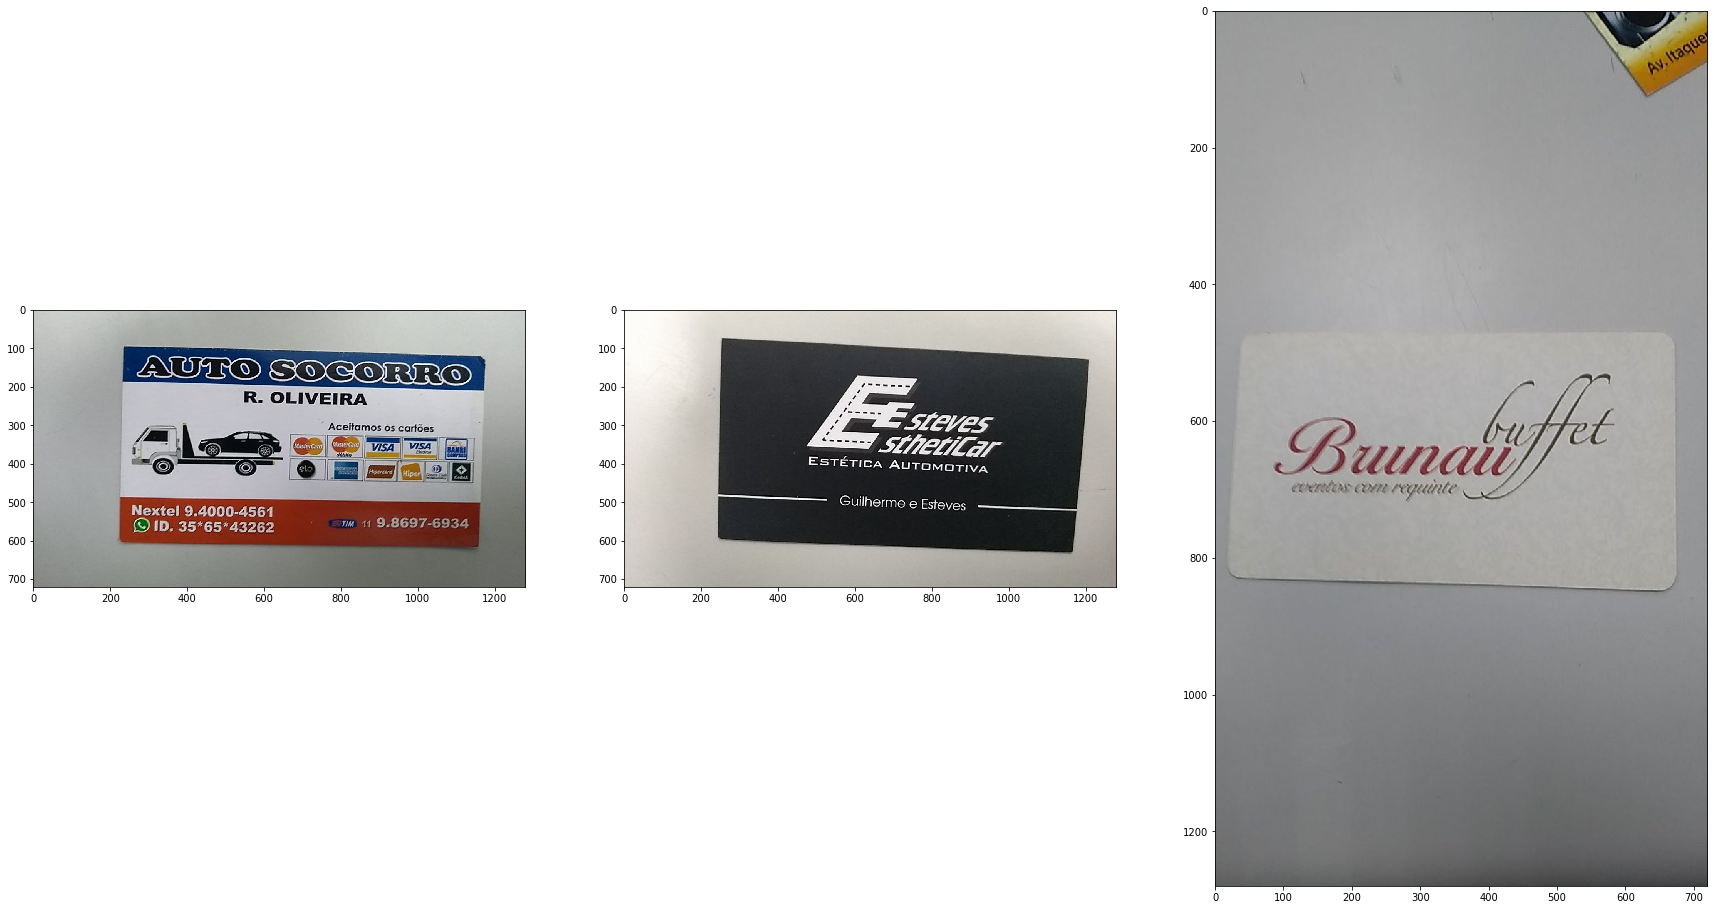

In [4]:
# Listing example files
example_files = [
    './images/' + f for f in os.listdir('./images')
    if os.path.isfile(os.path.join('./images', f))
]
# Selecting files for testing
file_img1 = example_files[np.random.randint(0, len(example_files))]
file_img2 = example_files[np.random.randint(0, len(example_files))]
file_img3 = example_files[np.random.randint(0, len(example_files))]
img1 = imageio.imread(file_img1)
img2 = imageio.imread(file_img2)
img3 = imageio.imread(file_img3)
plt.figure(figsize=(30, 30))
plt.subplot(131)
plt.imshow(img1)
plt.subplot(132)
plt.imshow(img2)
plt.subplot(133)
plt.imshow(img3)
plt.show()

## Development stages

The development of this project consisted of three steps: corner detection, perspective transform, and text recognition. For each of those phases, a Python module was created at the repository. Each of these modules was programmed to be independent of the other ones, and consists of a class (CornerDetector, PerspectiveTransform, TextDetector) and a main function exemplifying the use of its methods. With that said, the project consists of three modules:

- [corner_detection](https://github.com/andremsouza/dip-project-business-card-recognition/blob/dev/corner_detection.py)
- [perspective_transform](https://github.com/andremsouza/dip-project-business-card-recognition/blob/dev/perspective_transform.py)
- [text_detection](https://github.com/andremsouza/dip-project-business-card-recognition/blob/dev/text_detection.py)

For testing purposes, it was also created the [shell](https://github.com/andremsouza/dip-project-business-card-recognition/blob/dev/shell.py) module, with a command line interface, in which the user can choose an image and visualize each step of the processing.

### Corner detection

This development stage aims to, given a digital image, find the four corners of the business card. For this purpose, we implemented the Harris Corner Detector and the Shi-Tomasi corner detector.

To obtain better results, there was an empirical decision on the pre-processing of the image for the corner detector function. For the best results on most of the images, we decided to, in this order, denoise the image using OpenCV's non-local means filter, convert the image to grayscale using the ITU-R 601-2 luma transform, filter the input image using the Sobel filter (from scikit-image) and binarize the image with thresholding using the Otsu's method. The resulting image is then given as a parameter to the corner detector.

For the corner detector, it was implemented a function to calculate the image derivatives in the X and Y dimensions, using convolution over the Sobel operators. With this result there is the construction of the structure tensor and calculation of the Harris (or the Shi-Tomasi) response $r$, for each pixel. For a given threshold, if $r > threshold$, then the pixel is considered a corner point and is added to a list of corner points of the image.

With the output of the corner detector, there was the decision to divide the image in four and, in each quadrant, select one pixel as the corner of the business card. For this, it was calculated the Euclidean distance from the pixel to the corner of the $NxM$ image ($(0,0);(0,M);(N,0);(N,M)$), for each pixel in its respective quadrant. For each quadrant, the closest pixel to the corners of the image is selected as a corner for the business card.

Below is a sample for the utilization of the corner detector, for the three selected images.

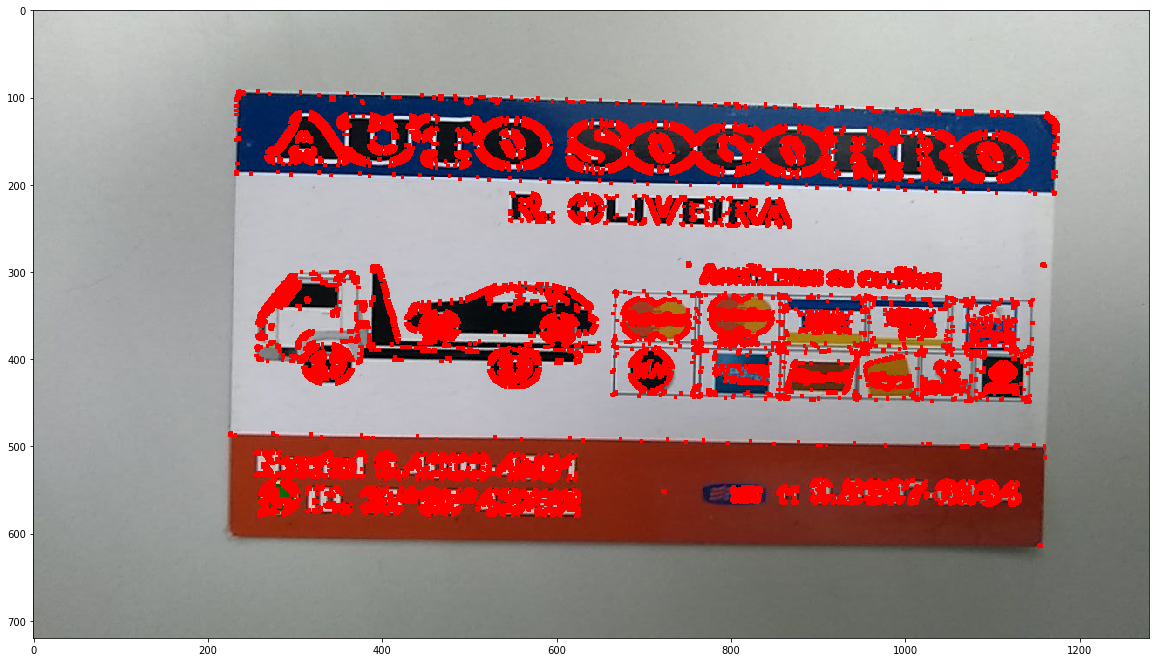

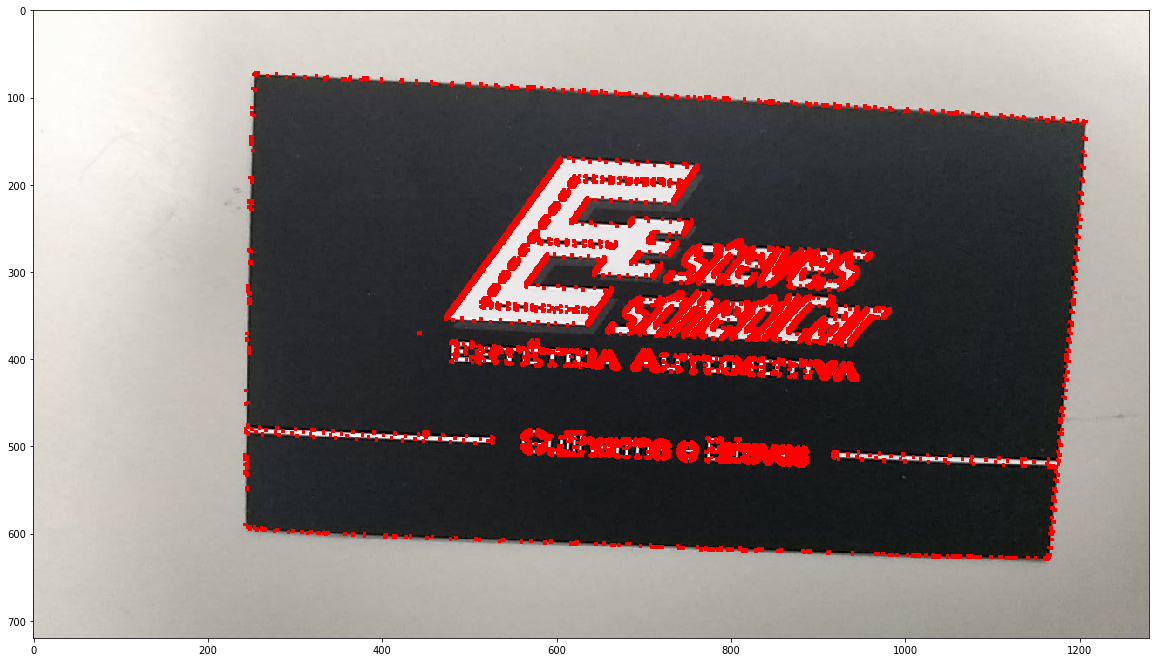

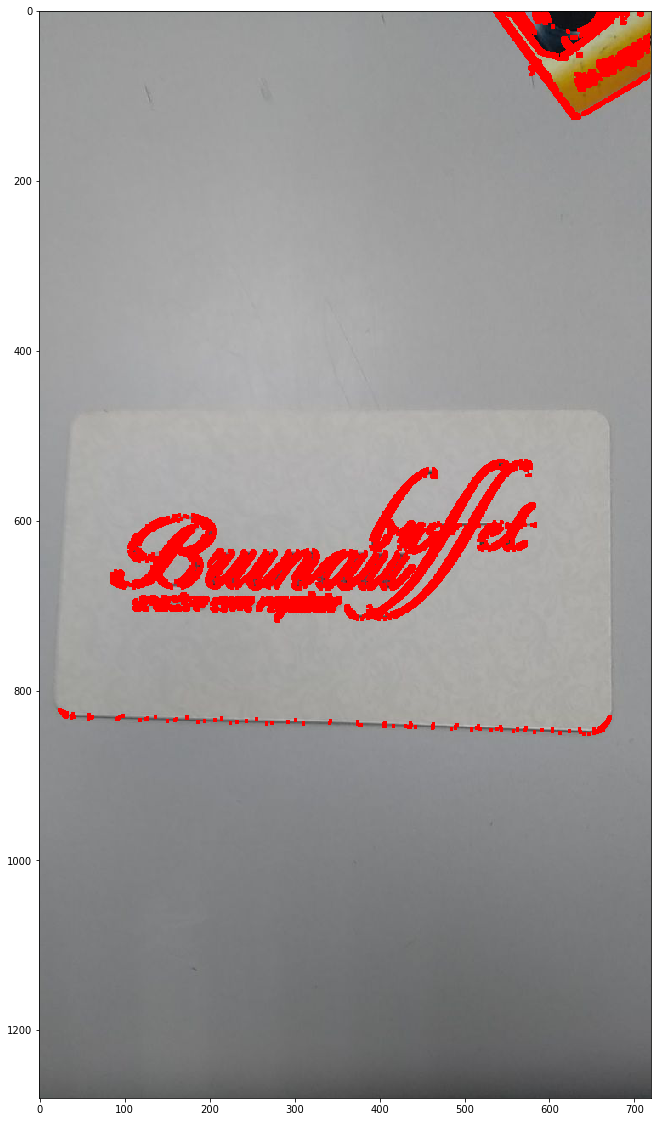

In [5]:
img1_corners = corner_detection.CornerDetector(img1).corner_detector()[0]
plt.figure(figsize=(20, 20))
plt.imshow(img1_corners)
plt.show()
img2_corners = corner_detection.CornerDetector(img2).corner_detector()[0]
plt.figure(figsize=(20, 20))
plt.imshow(img2_corners)
plt.show()
img3_corners = corner_detection.CornerDetector(img3).corner_detector()[0]
plt.figure(figsize=(20, 20))
plt.imshow(img3_corners)
plt.show()

#### Problems of the corner detector

For this implementation, when there are various objects in the image, there may be pixels wrongly classified as corners, which may prove dificult if these are too distant from the real corners of the business card. Also, in the cases of business cards that are too similar to the background (e.g. white business card on white background), the transitions may not be significant enough for the default threshold, and the corner of the business card may not be consired a corner by the algorithm.

For both of the mentioned cases, the next stage of the business card recognition may have an extreme behaviour.

### Perspective transform

This development stage's objective is to, given a digital image and four coordinates, perform the four point projective transform, effectively repairing the perspective of the original image. If the points are correctly given, this algorithm can normalize the rotation of the business card and remove the background. However, if the points are not correctly given (as explained in the last stage), there may be some distortions in the resulting image. For this stage, we've made our own implementation and got acceptable results, when comparing to OpenCV's implementation.

To perform the projective transform, we calculate and create a new destination image, using the four points given by the user (or the corner detection algorithm). Then we compute the projective mappings of the four corner points both at the source ($A$) image and the destination ($B$) image, to build the transform matrix $M= BA^{-1}$. With that, given a coordinate $P=(x_1,y_1,1)$ from the source image and the $3x3$ transform matrix $M$, we have that $MP=Q$, where $Q=(x_2,y_2,1)$ is the equivalent coordinate of $P$ in the destination image.

To compute the transform, we round the resulting coordinates to the nearest pixel and, at the end of the computation, perform a median denoise on every "unpainted" pixel in the destination image.

Below is the algorithm at work, using the three sample images and the output of the corner detector.

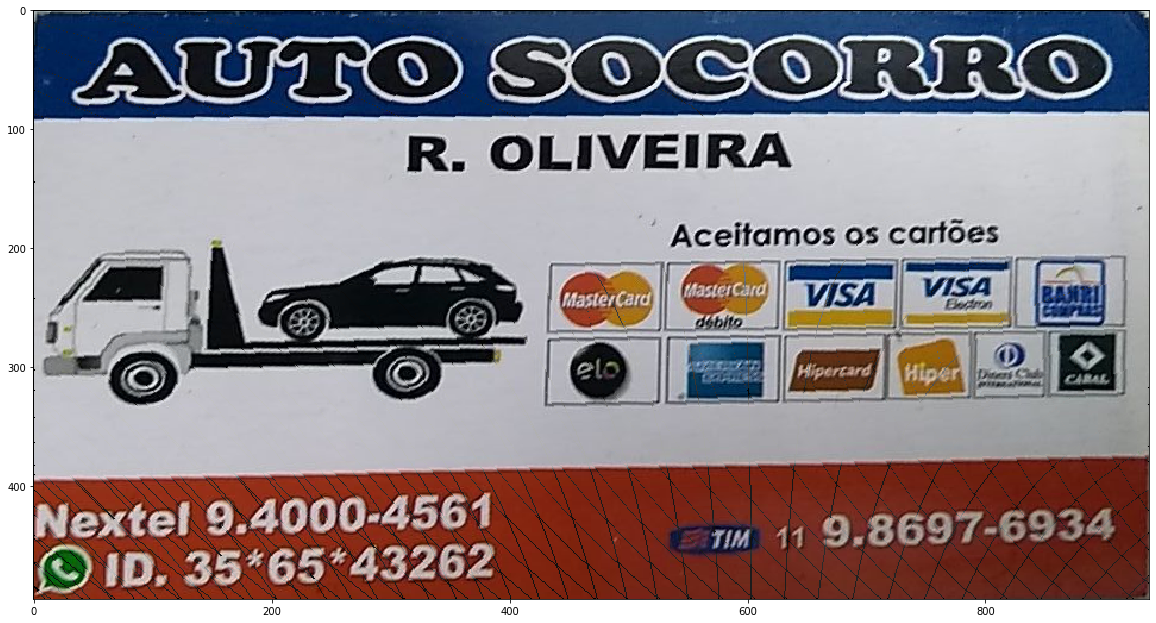

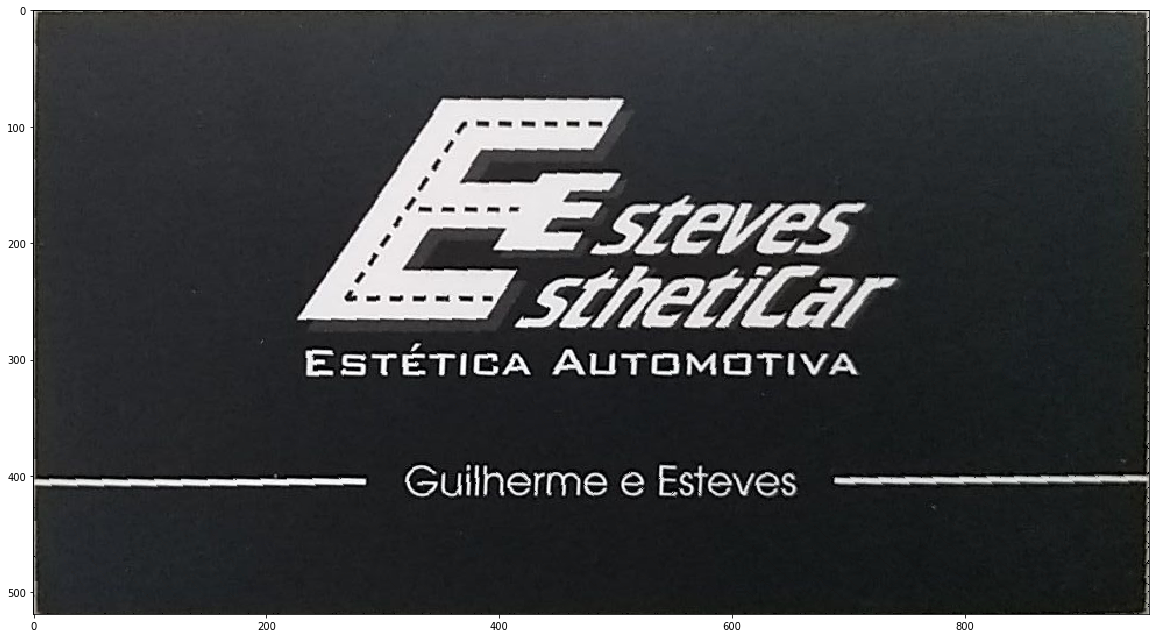

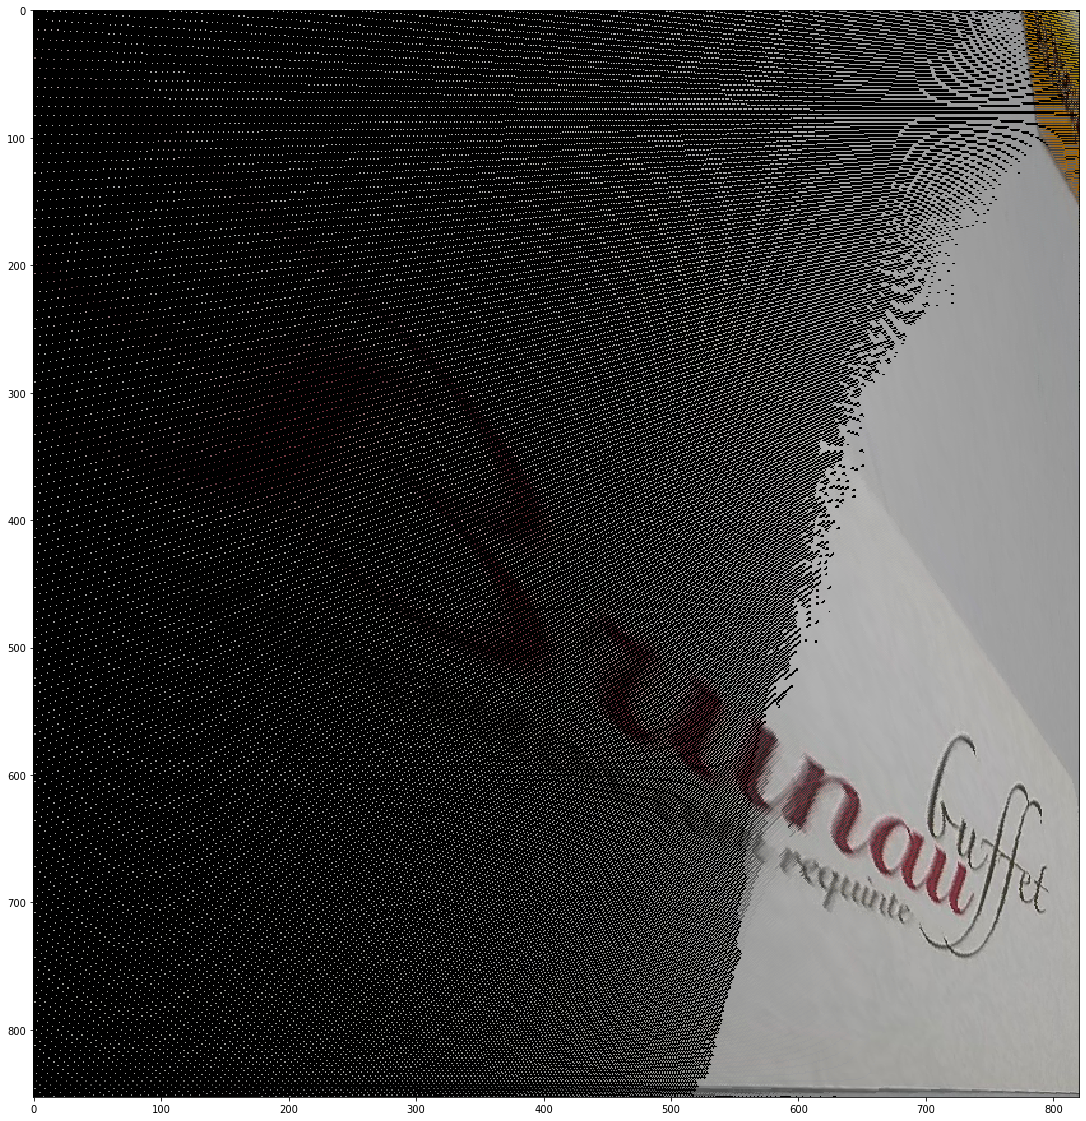

In [6]:
corner_points1 = corner_detection.CornerDetector(img1).find_corners4().astype(
    np.float32)
corner_points1[:, [0, 1]] = corner_points1[:, [1, 0]]
img1_t = perspective_transform.PerspectiveTransform(
    img1, corner_points1).four_point_transform()
plt.figure(figsize=(20, 20))
plt.imshow(img1_t)
plt.show()

corner_points2 = corner_detection.CornerDetector(img2).find_corners4().astype(
    np.float32)
corner_points2[:, [0, 1]] = corner_points2[:, [1, 0]]
img2_t = perspective_transform.PerspectiveTransform(
    img2, corner_points2).four_point_transform()
plt.figure(figsize=(20, 20))
plt.imshow(img2_t)
plt.show()

corner_points3 = corner_detection.CornerDetector(img3).find_corners4().astype(
    np.float32)
corner_points3[:, [0, 1]] = corner_points3[:, [1, 0]]
img3_t = perspective_transform.PerspectiveTransform(
    img3, corner_points3).four_point_transform()
plt.figure(figsize=(20, 20))
plt.imshow(img3_t)
plt.show()

#### Problems

Due to rounding, some pixels may not be painted, which can be remediated with the median denoise, but in some cases this error is very visible. Also, as stated previously, if the points are not correctly given, this can cause a distortion in the transformation, where many resulting pixels may become unpainted.

### Text detection / recognition

This is the last development stage, and its objective is to detect text regions in a digital image. For this purpose, we used morphological image processing techniques with the OpenCV's functions. In this stage, we use OpenCV to load and process the image, generating potential regions of the image with text, and Tesseract to recognize text in each of the regions.

The image, which can be the output of the previous stage, is preprocessed with conversion to grayscale, filtering with the Sobel filter in the X direction only (to find "left-to-right" transitions), and applying the Otsu's method for thresholding, effectively generating a binary image.

After the pre-processing, the TextDetector class utilizes the closing operation, from morphological image processing, with a rectangular structuring element of variable shape (default 17x3). This operation "joins" characters into a region of text, which we then get the contours of with the Suzuki algorithm implementation in OpenCV. For each of the contours, the TextDetector finds its bounding rectangle and verify it's shape, and if the $width/height$ ratio of the rectangle is larger than 1, then we consider this region as a potential text region.

For each of the rectangular regions in which there were text detected, the TextDetector pass the input image in this region to the Tesseract neural network, that then tries to recognize any text within.

Below is a sample of the utilization of the TextDetector, with the result of the previous stage using the sample images.

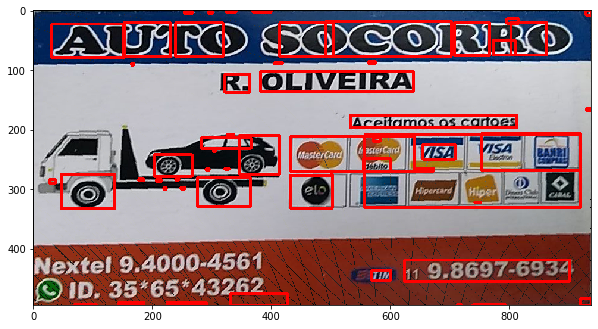








7IM
11 93597-69334







©17-
‘ 3

r;/@ l






VISA






VISA

1.1;”,
Aceltamos os canées


OLIVEIRA



















In [7]:
img1_t_cv = cv2.cvtColor(img1_t, cv2.COLOR_RGB2BGR)
# Finding text areas
img1_t_cv = cv2.cvtColor(img1_t, cv2.COLOR_RGB2BGR)
size = (17, 3)
strs, bound_rects, img_bboxes = text_detection.TextDetector(img1_t_cv,
                                                            size).recognize_text()
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_bboxes, cv2.COLOR_BGR2RGB))
plt.show()
print(*strs, sep='\n')

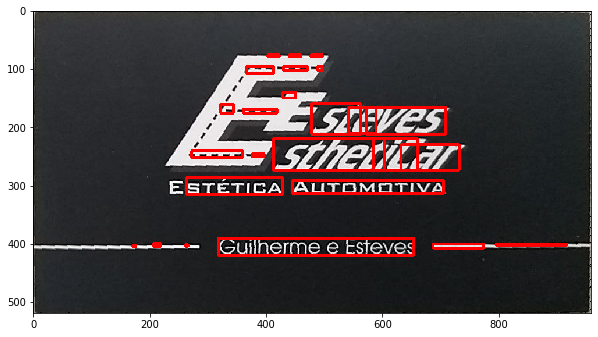






Guilherme e Esteves
ALITU MDTIVA
STéTIcA

L---—

527762}




I—


‘ A







In [8]:
img2_t_cv = cv2.cvtColor(img2_t, cv2.COLOR_RGB2BGR)
# Finding text areas
img2_t_cv = cv2.cvtColor(img2_t, cv2.COLOR_RGB2BGR)
size = (17, 3)
strs, bound_rects, img_bboxes = text_detection.TextDetector(img2_t_cv,
                                                            size).recognize_text()
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_bboxes, cv2.COLOR_BGR2RGB))
plt.show()
print(*strs, sep='\n')

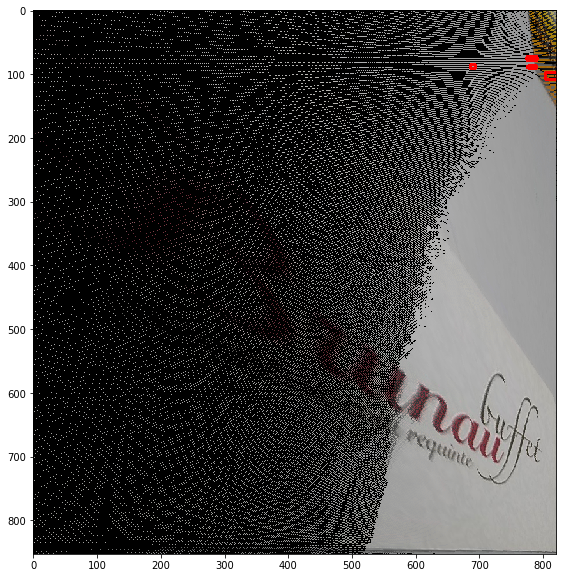

In [9]:
img3_t_cv = cv2.cvtColor(img3_t, cv2.COLOR_RGB2BGR)
# Finding text areas
img3_t_cv = cv2.cvtColor(img3_t, cv2.COLOR_RGB2BGR)
size = (17, 3)
strs, bound_rects, img_bboxes = text_detection.TextDetector(img3_t_cv,
                                                            size).recognize_text()
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_bboxes, cv2.COLOR_BGR2RGB))
plt.show()
print(*strs, sep='\n')

#### Problems

Due to time issues, we couldn't implement the segmentation to a lower level (instead of detecting lines of text, detecting individual characters). With that, the Tesseract isn't always able to recognize the text, mainly when there are stylized fonts. Also, problems with the resolution of the image may lead to futher misclassifications.

## Final considerations

In this project, we could utilize some concepts taught in this discipline that can be very useful in practical matters. Even tough the results were not perfect, with many problems due to the large variation in the input images, the implementation of some of those methods helped us to have a strong base to learn, understand and implement more complex features of digital image processing.